# Projet ML2: US elections
# Sylvie Jarjayes

# 1.Données des élections 2020:
## import, création target, premières stats, création features: état + longitude et latitude

## 1.1 Import Données et création target

In [ ]:
#!pip install mlxtend

In [203]:
#!pip install xgboost

In [257]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer

from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import f1_score, make_scorer

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    cross_val_predict
)

import xgboost as xgb
from sklearn import metrics

import sklearn as sk

In [2]:
# Propriétés d'affichage

pd.options.display.max_columns = None
pd.options.display.max_rows = None



In [3]:
# Vérification des fichiers présents dans le répertoire courant
os.listdir()

['.ipynb_checkpoints',
 '.~lock.Education.xls#',
 '.~lock.PopulationEstimates.xls#',
 '.~lock.PovertyEstimates.xls#',
 '.~lock.state_code.csv#',
 '05_support_vector_machines.ipynb.txt',
 '2020_US_County_Level_Presidential_Results.csv',
 'county_statistics.csv',
 'Education.xls',
 'PopulationEstimates.xls',
 'PovertyEstimates.xls',
 'projet_ml2_us_elections.ipynb',
 'projet_ml2_us_elections_15102022.ipynb',
 'projet_ml2_us_elections_16102022.ipynb',
 'projet_ml2_us_elections_v2.ipynb',
 'projet_ml2_us_elections_v3.ipynb',
 'SDA - Projet Classification.pdf',
 'state_code.csv',
 'Untitled.ipynb',
 'us_county_latlng.csv']

In [3]:
# Import des données des élections 2020
data = pd.read_csv('2020_US_County_Level_Presidential_Results.csv')
# Visu
data.head()

state_name  county_fips     county_name  votes_gop  votes_dem  total_votes  \
0    Alabama         1001  Autauga County      19838       7503        27770   
1    Alabama         1003  Baldwin County      83544      24578       109679   
2    Alabama         1005  Barbour County       5622       4816        10518   
3    Alabama         1007     Bibb County       7525       1986         9595   
4    Alabama         1009   Blount County      24711       2640        27588   

    diff   per_gop   per_dem  per_point_diff  
0  12335  0.714368  0.270184        0.444184  
1  58966  0.761714  0.224090        0.537623  
2    806  0.534512  0.457882        0.076631  
3   5539  0.784263  0.206983        0.577280  
4  22071  0.895716  0.095694        0.800022

In [4]:
# Création de la target/ 1 si votes rep > votes dem
data['target']=0
data['target'].loc[data['diff']>0]=1
data.drop(columns=['diff','per_point_diff'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state_name   3152 non-null   object 
 1   county_fips  3152 non-null   int64  
 2   county_name  3152 non-null   object 
 3   votes_gop    3152 non-null   int64  
 4   votes_dem    3152 non-null   int64  
 5   total_votes  3152 non-null   int64  
 6   per_gop      3152 non-null   float64
 7   per_dem      3152 non-null   float64
 8   target       3152 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 221.8+ KB


C:\Users\jarjayes\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
print(f"data comporte {data.shape[0]} lignes et  {data.shape[1]} colonnes.")

data comporte 3152 lignes et  9 colonnes.


## 1.2 Bilan des votes par état

In [6]:
# Import d'un fichier contenant les codes des états
state_code = pd.read_csv('state_code.csv')
state_code.head()

State Alpha code
0     Alabama         AL
1      Alaska         AK
2     Arizona         AZ
3    Arkansas         AR
4  California         CA

In [7]:
# Création d'une colonne avec les codes des états: première colonne de data
state_code = state_code.rename(columns={'State':'state_name'} )
state_code = state_code.rename(columns={'Alpha code':'state_code'} )
data = pd.merge(data, state_code, how="left", on=["state_name"])
first_column = data.pop('state_code')
data.insert(0, 'state_code', first_column)
data.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target  
0        27770  0.714368  0.270184       1  
1       109679  0.761714  0.224090       1  
2        10518  0.534512  0.457882       1  
3         9595  0.784263  0.206983       1  
4        27588  0.895716  0.095694       1

In [8]:
# Création de data_by_state: bilan des votes par états
data_by_state = data.groupby('state_code')[['votes_gop','votes_dem']].sum().sort_values(by='state_code')
data_by_state['pc_dem']=data_by_state['votes_dem']/(data_by_state['votes_gop']+data_by_state['votes_dem'])
data_by_state['pc_gop'] = 1-data_by_state['pc_dem']
data_by_state.head()

votes_gop  votes_dem    pc_dem    pc_gop
state_code                                          
AK             189892     153405  0.446858  0.553142
AL            1441168     849648  0.370893  0.629107
AR             760647     423932  0.357876  0.642124
AZ            1661686    1672143  0.501568  0.498432
CA            6005961   11109764  0.649097  0.350903

In [9]:
# Carte des US avec le % de votes pour les Dem par état
fig = px.choropleth(data_by_state,
                   locations=data_by_state.index,
                   locationmode='USA-states',
                   scope='usa',
                   color = 'pc_dem',
                   hover_data = ['pc_gop', 'pc_dem'],
                   color_continuous_scale = 'viridis_r',
                   range_color = [0.1,0.9])

fig.add_scattergeo(
    locations=data_by_state.index,
    hoverinfo='skip',
    locationmode='USA-states',
    text=data_by_state.index,
    mode='text')

fig.update_layout(
    title={'text':'Vote share of Democrats in 2020 election',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})


fig.show()

In [10]:
# Bilan par état: votes dem vs gop
color_1 = plt.cm.Reds(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Blues(np.linspace(0.6, 1, 66))
sns.set(font_scale=1.5)

def data_by_state_bar(data1, data2):
    x = np.arange(51)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
    w = 0.3
    i = 0
    color = color_1
    plt.title('Number of votes by political party in 2020: Blue=Dem, Red=Rep')
    plt.xticks(x + w /2, data_by_state.index, rotation='90')
    ax.set_xlabel('States')
    ax.set_ylabel('Number of of votes in 2020')
    ax.bar(x,data_by_state[data1].values,color=color_1,width=w,align='center')

    color = color_2
    ax1 = ax
    ax1.bar(x + w,data_by_state[data2].values, color=color_2,width=w,align='center')

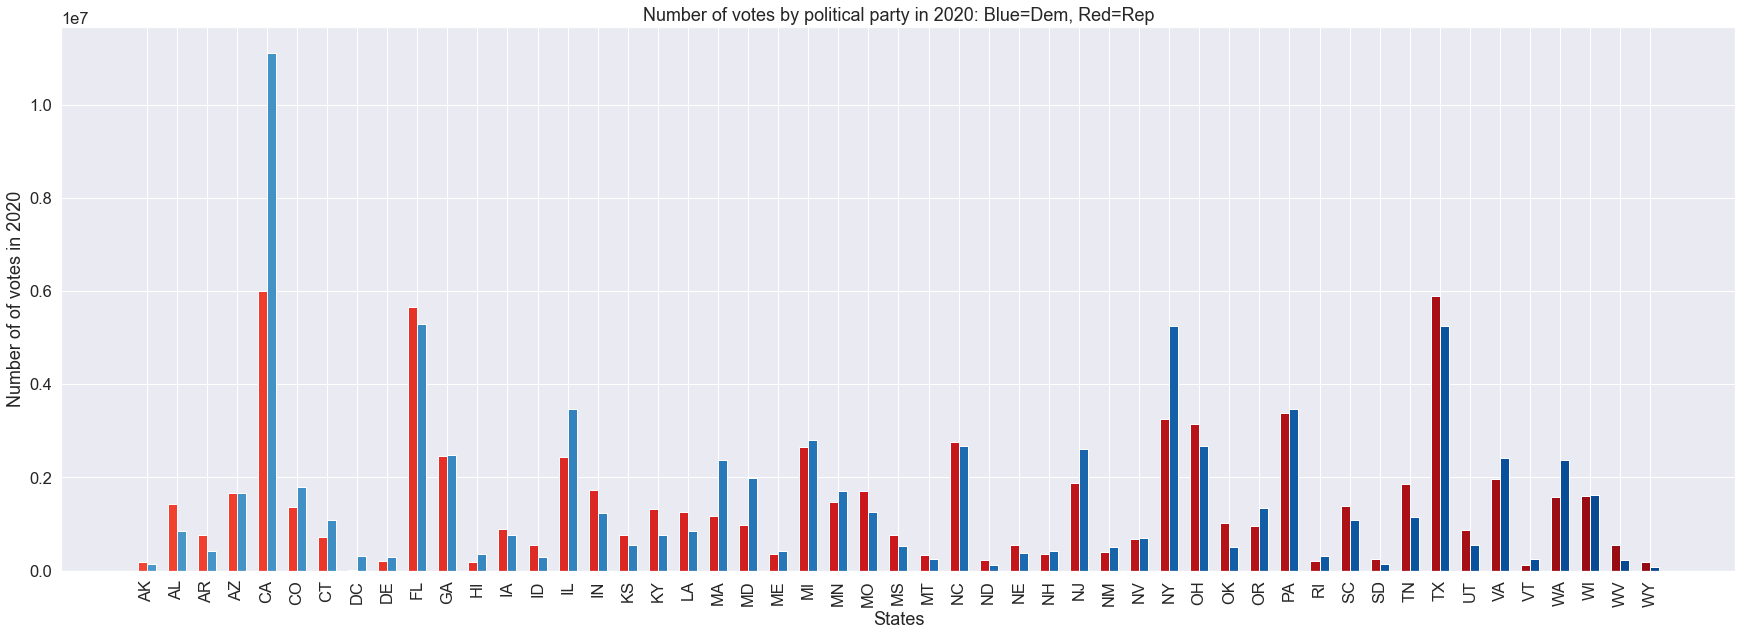

In [11]:
data_by_state_bar('votes_gop', 'votes_dem')

## 1.3 Import latitude et longitude pour visualisation

In [12]:
# Import data localisation: fips, long, lat
data_loc = pd.read_csv('us_county_latlng.csv')

In [13]:
# Classement par fips croissant puis visu premières lignes
data_loc.sort_values(by=['fips_code']).head()

fips_code     name        lng        lat
2527       1001  Autauga -86.642900  32.535142
145        1003  Baldwin -87.722745  30.727825
2528       1005  Barbour -85.391068  31.870090
2058       1007     Bibb -87.126814  32.998376
3052       1009   Blount -86.567006  33.980871

In [14]:
# Il y a plus de fips code que dans les data des élections
data_loc.drop(columns=['name'], inplace=True)

In [15]:
# On renomme la colonne des fips avant de merger: création de data_geo: data+long+lat
data_loc = data_loc.rename(columns={'fips_code':'county_fips'} )
data_geo = pd.merge(data, data_loc, how="left", on=["county_fips"])
data_geo.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target        lng        lat  
0        27770  0.714368  0.270184       1 -86.642900  32.535142  
1       109679  0.761714  0.224090       1 -87.722745  30.727825  
2        10518  0.534512  0.457882       1 -85.391068  31.870090  
3         9595  0.784263  0.206983       1 -87.126814  32.998376  
4        27588  0.895716  0.095694       1 -86.567006  33.980871

Text(0.5, 1.0, 'The 2020 Election: percentage of Democratic votes')

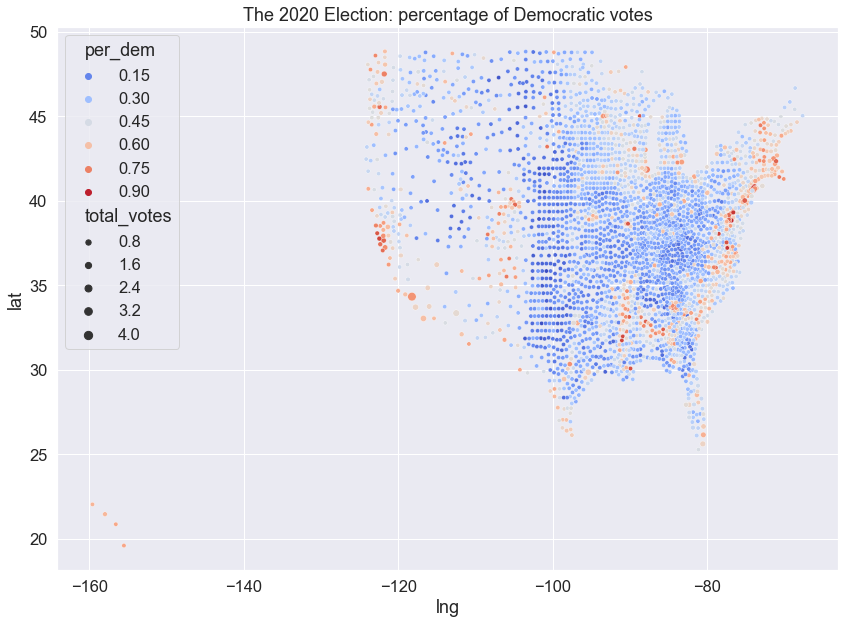

In [16]:
# Scatter plot des votes dem en utilisant la longitute et la latitude
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_geo, x = "lng", y = "lat", hue = "per_dem", palette = "coolwarm", size='total_votes')
plt.title("The 2020 Election: percentage of Democratic votes")

## 1.4 Import Education: analyse des variables influentes

In [17]:
education = pd.read_excel('Education.xls', skiprows = 4)
education.head()

FIPS Code State       Area name  2003 Rural-urban Continuum Code  \
0          0    US   United States                              NaN   
1       1000    AL         Alabama                              NaN   
2       1001    AL  Autauga County                              2.0   
3       1003    AL  Baldwin County                              4.0   
4       1005    AL  Barbour County                              6.0   

   2003 Urban Influence Code  2013 Rural-urban Continuum Code  \
0                        NaN                              NaN   
1                        NaN                              NaN   
2                        2.0                              2.0   
3                        5.0                              3.0   
4                        6.0                              6.0   

   2013 Urban Influence Code  Less than a high school diploma, 1970  \
0                        NaN                             52373312.0   
1                        NaN                              1062306.0   
2                        2.0                                 6611.0   
3                        2.0                                18726.0   
4                        6.0                                 8120.0   

   High school diploma only, 1970  Some college (1-3 years), 1970  \
0                      34158051.0                      11650730.0   
1                        468269.0                        136287.0   
2                          3757.0                           933.0   
3                          8426.0                          2334.0   
4                          2242.0                           581.0   

   Four years of college or higher, 1970  \
0                             11717266.0   
1                               141936.0   
2                                  767.0   
3                                 2038.0   
4                                  861.0   

   Percent of adults with less than a high school diploma, 1970  \
0                                               47.7              
1                                               58.7              
2                                               54.8              
3                                               59.4              
4                                               68.8              

   Percent of adults with a high school diploma only, 1970  \
0                                               31.1         
1                                               25.9         
2                                               31.1         
3                                               26.7         
4                                               19.0         

   Percent of adults completing some college (1-3 years), 1970  \
0                                               10.6             
1                                                7.5             
2                                                7.7             
3                                                7.4             
4                                                4.9             

   Percent of adults completing four years of college or higher, 1970  \
0                                               10.7                    
1                                                7.8                    
2                                                6.4                    
3                                                6.5                    
4                                                7.3                    

   Less than a high school diploma, 1980  High school diploma only, 1980  \
0                             44535197.0                      45947035.0   
1                               964840.0                        704207.0   
2                                 7074.0                          6145.0   
3                                18125.0                         15380.0   
4                                 7759.0                          3671.0   

   Some c

In [19]:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3283 entries, 0 to 3282
Data columns (total 47 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   FIPS Code                                                                 3283 non-null   int64  
 1   State                                                                     3283 non-null   object 
 2   Area name                                                                 3283 non-null   object 
 3   2003 Rural-urban Continuum Code                                           3221 non-null   float64
 4   2003 Urban Influence Code                                                 3221 non-null   float64
 5   2013 Rural-urban Continuum Code                                           3221 non-null   float64
 6   2013 Urban Influence Code                                       

In [18]:
education.drop(columns=['Area name', '2003 Rural-urban Continuum Code',
                       '2003 Urban Influence Code','2013 Rural-urban Continuum Code' ,
                       '2013 Urban Influence Code'], inplace=True)


In [19]:
# On renomme les colonnes des pourcentages en fonction des diplômes depuis 1990
list_niveau= ['Percent of adults with less than a high school diploma, ',
             'Percent of adults with a high school diploma only, ',
              "Percent of adults completing some college or associate's degree, ",
             "Percent of adults with a bachelor's degree or higher, "]
short_niveau=["pc_no_diploma", "pc_high_school", "pc_degree", "pc_high_degree"]


list_year = ['1990', '2000', '2015-19']
short_year = ['90', '00', '15-19']

def rename_education(old_name, new_name):

    for i,x in enumerate(list_year) :
        abrev = short_year[i]
        old = old_name+x
        new = new_name+'_'+abrev
        education.rename(columns={old: new}, inplace=True)

In [20]:
for i,x in enumerate(list_niveau):
    old_name=x
    new_name=short_niveau[i]
    rename_education(old_name, new_name)

In [21]:
col_educ= education.columns.tolist()
col_sel=['FIPS Code','pc_no_diploma_90', 'pc_high_school_90','pc_degree_90','pc_high_degree_90',
'pc_no_diploma_00','pc_high_school_00','pc_degree_00','pc_high_degree_00',  'pc_no_diploma_15-19',
'pc_high_school_15-19', 'pc_degree_15-19','pc_high_degree_15-19']  

In [22]:
education_short=education[col_sel]
education_short.head()

FIPS Code  pc_no_diploma_90  pc_high_school_90  pc_degree_90  \
0          0              24.8               30.0          24.9   
1       1000              33.1               29.4          21.7   
2       1001              30.0               32.0          23.5   
3       1003              26.8               31.8          24.6   
4       1005              44.4               27.1          16.7   

   pc_high_degree_90  pc_no_diploma_00  pc_high_school_00  pc_degree_00  \
0               20.3              19.6               28.6          27.4   
1               15.7              24.7               30.4          25.9   
2               14.5              21.3               33.8          26.9   
3               16.8              18.0               29.6          29.3   
4               11.8              35.3               32.4          21.3   

   pc_high_degree_00  pc_no_diploma_15-19  pc_high_school_15-19  \
0               24.4            11.998918             26.956844   
1               19.0            13.819302             30.800268   
2               18.0            11.483395             33.588459   
3               23.1             9.193843             27.659616   
4               10.9            26.786907             35.604542   

   pc_degree_15-19  pc_high_degree_15-19  
0        28.898697             32.145542  
1        29.912098             25.468332  
2        28.356571             26.571573  
3        31.284081             31.862459  
4        26.029837             11.578713

In [40]:
#print(f"education comporte {education.shape[0]} lignes et  {education.shape[1]} colonnes.")

In [23]:
# Fusion data et population: il faut d'abord renommer la colonne fips de population
education_short.rename(columns={'FIPS Code':'county_fips'}, inplace=True)
# Merge des 2 dataframe: on ne conserve que les codes fips présents dans data
data_educ = pd.merge(data_geo, education_short, how="left", on=["county_fips"])


C:\Users\jarjayes\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
#print(f"data_educ comporte {data_educ.shape[0]} lignes et  {data_educ.shape[1]} colonnes.")

In [27]:
#data_educ.head()

In [24]:
data_educ_state = data_educ.groupby(by=['state_name']).median()
data_educ_state.head()

county_fips  votes_gop  votes_dem  total_votes   per_gop  \
state_name                                                             
Alabama          1067.0    10848.0     4816.0      15910.0  0.706430   
Alaska           2920.5     4597.5     3688.0       9500.0  0.473710   
Arizona          4013.0    27657.0    23732.0      60473.0  0.578679   
Arkansas         5075.0     5355.0     1772.0       7351.0  0.721157   
California       6058.0    27114.5    49404.0      91720.5  0.447497   

             per_dem  target         lng        lat  pc_no_diploma_90  \
state_name                                                              
Alabama     0.279752     1.0  -86.661375  32.853304              41.9   
Alaska      0.460268     1.0         NaN        NaN               NaN   
Arizona     0.405897     1.0 -111.344880  33.348760              31.9   
Arkansas    0.245441     1.0  -92.502534  35.002707              38.9   
California  0.532454     0.0 -120.918094  38.050501              21.8   

            pc_high_school_90  pc_degree_90  pc_high_degree_90  \
state_name                                                       
Alabama                  30.7          17.0              10.00   
Alaska                    NaN           NaN                NaN   
Arizona                  27.7          26.4              10.80   
Arkansas                 34.3          17.0               9.30   
California               25.4          31.9              16.35   

            pc_no_diploma_00  pc_high_school_00  pc_degree_00  \
state_name                                                      
Alabama                 31.6               33.4         22.90   
Alaska                   NaN                NaN           NaN   
Arizona                 22.5               27.7         32.70   
Arkansas                28.4               36.8         21.60   
California              19.1               24.2         33.65   

            pc_high_degree_00  pc_no_diploma_15-19  pc_high_school_15-19  \
state_name                                                                 
Alabama                  11.1            17.657822             35.960445   
Alaska                    NaN                  NaN                   NaN   
Arizona                  12.3            13.932610             28.660160   
Arkansas                 11.1            15.520604             38.887939   
California               17.6            13.462424             24.337049   

            pc_degree_15-19  pc_high_degree_15-19  
state_name                                         
Alabama           29.055319             15.271235  
Alaska                  NaN                   NaN  
Arizona           36.969063             18.733791  
Arkansas          29.120491             15.088283  
California        33.420990             24.074049

In [25]:
def data_educ_bar():
    x = np.arange(51)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
    w = 0.3
    i = 0

    plt.title('Median pourcentage of no diploma in 2015-19 per state')
    plt.xticks(x + w /2, data_educ_state.index, rotation='90')
    ax.set_xlabel('States')
    ax.set_ylabel('Mean percentage no diploma in 2015-2019')
    
    sns.barplot( x=data_educ_state.index, y='pc_no_diploma_15-19', hue='target', data=data_educ_state)


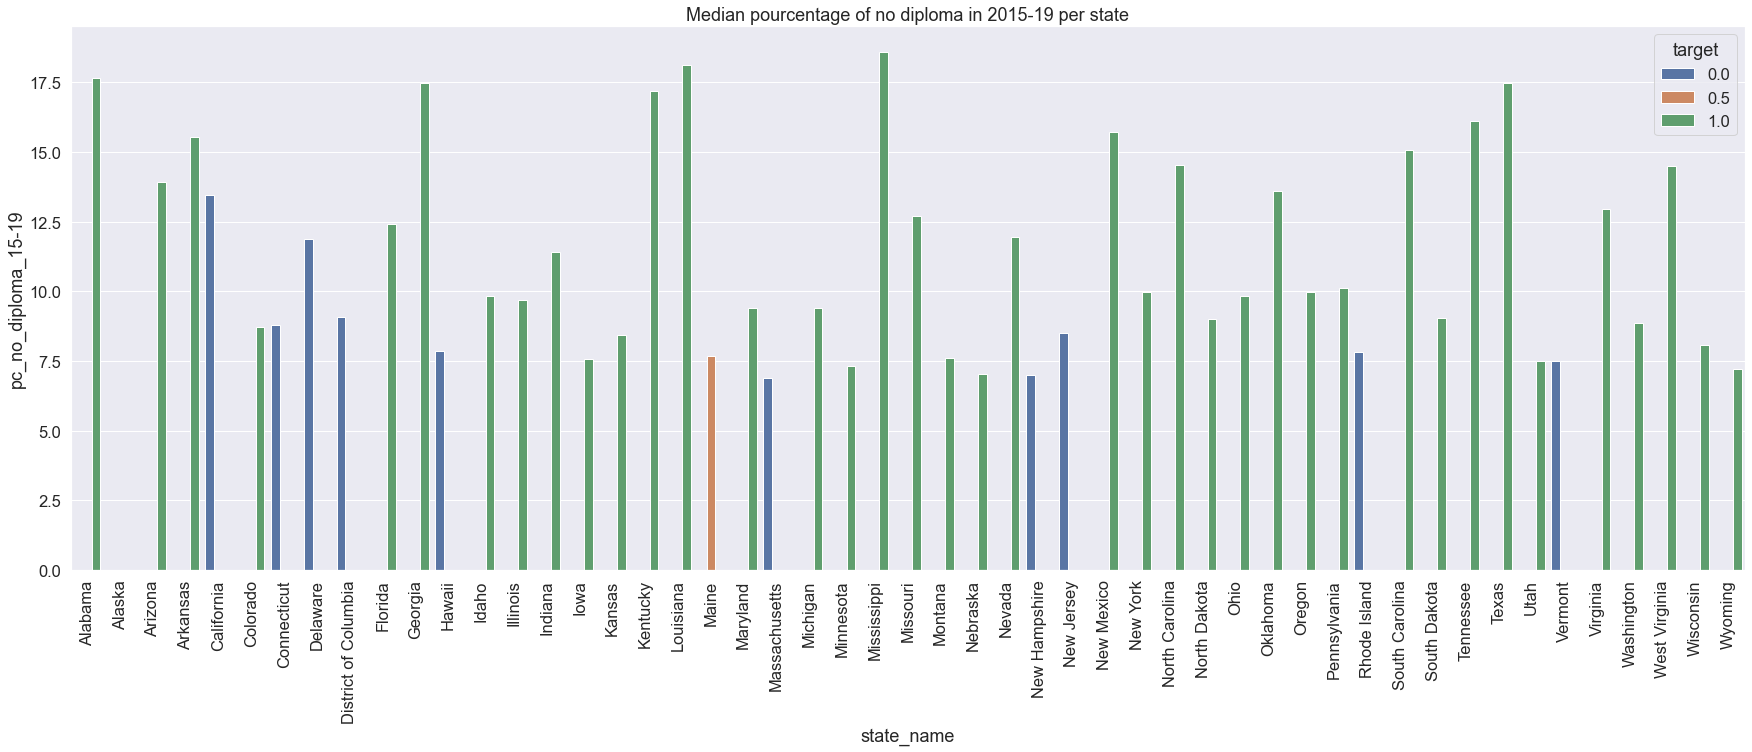

In [26]:
sns.set(font_scale=1.5)
data_educ_bar()

<AxesSubplot:xlabel='target', ylabel='pc_high_degree_15-19'>

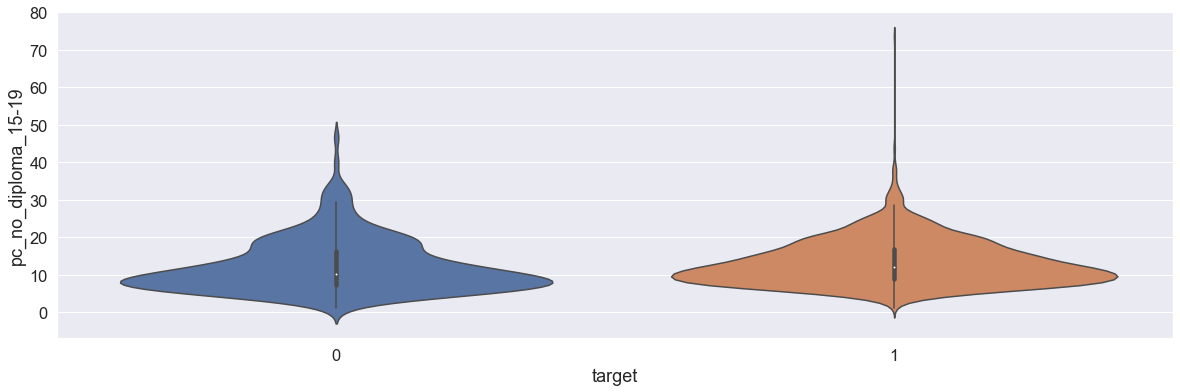

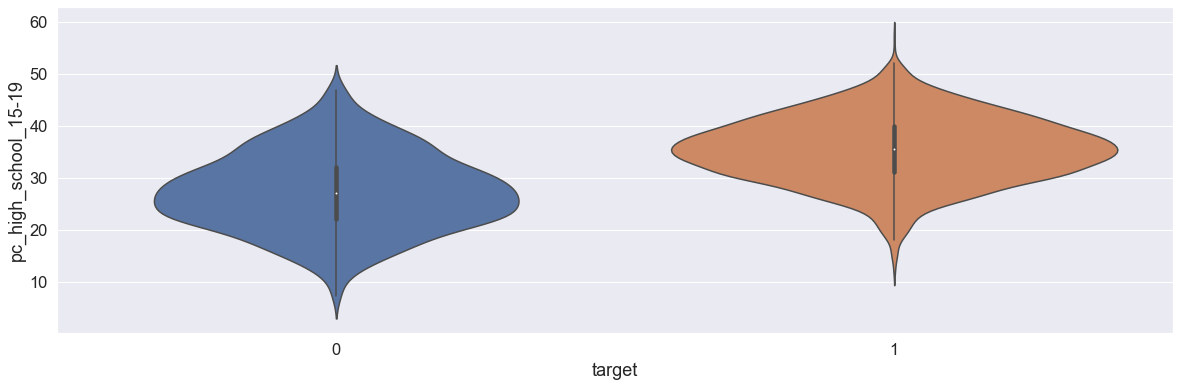

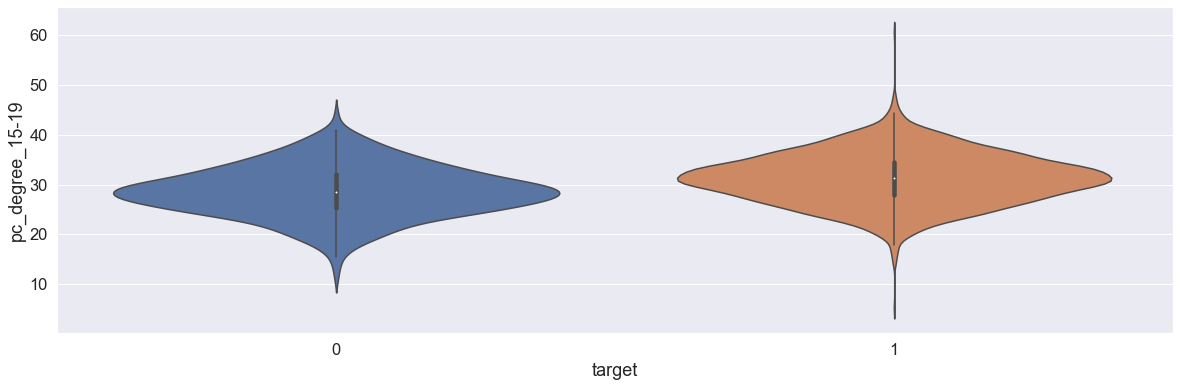

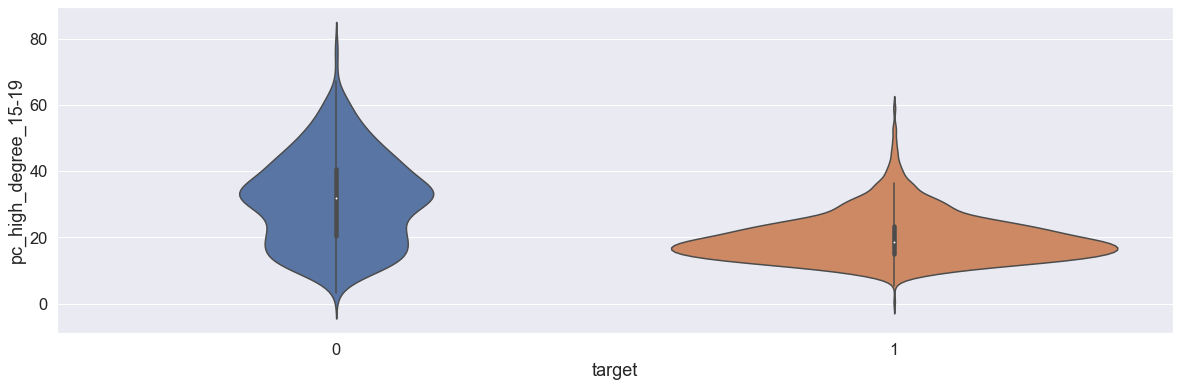

In [27]:
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_no_diploma_15-19', data=data_educ, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_high_school_15-19', data=data_educ, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_degree_15-19', data=data_educ, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_high_degree_15-19', data=data_educ, ax=ax)

Text(0.5, 1.0, 'The 2020 Election: percentage of Democratic votes')

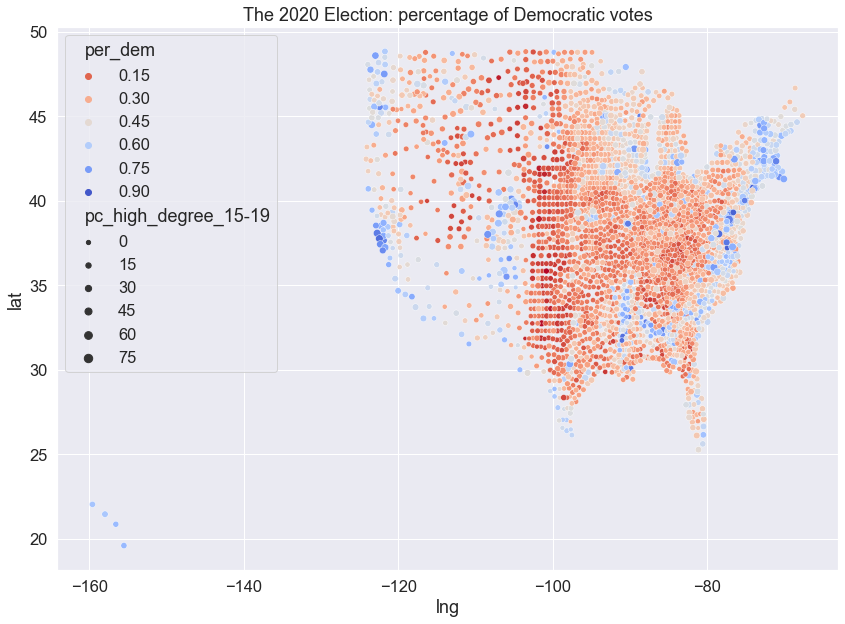

In [28]:
# Influence of the scholar level on dem vote
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_educ, x = "lng", y = "lat", 
                hue = "per_dem", palette = "coolwarm_r", size='pc_high_degree_15-19')
plt.title("The 2020 Election: percentage of Democratic votes")


In [155]:
#data_educ.drop(columns=['county_fips','votes_gop','votes_dem']).corr()['target']

## 1.5 Import poverty: analyse des variables influentes

In [33]:
#os.listdir()

In [29]:
poverty = pd.read_excel('PovertyEstimates.xls', skiprows = 4)
poverty.head()

FIPStxt Stabr       Area_name  Rural-urban_Continuum_Code_2003  \
0        0    US   United States                              NaN   
1     1000    AL         Alabama                              NaN   
2     1001    AL  Autauga County                              2.0   
3     1003    AL  Baldwin County                              4.0   
4     1005    AL  Barbour County                              6.0   

   Urban_Influence_Code_2003  Rural-urban_Continuum_Code_2013  \
0                        NaN                              NaN   
1                        NaN                              NaN   
2                        2.0                              2.0   
3                        5.0                              3.0   
4                        6.0                              6.0   

   Urban_Influence_Code_2013  POVALL_2019  CI90LBALL_2019  CI90UBALL_2019  \
0                        NaN     39490096        39248096        39732096   
1                        NaN       747478          730491          764465   
2                        2.0         6723            5517            7929   
3                        2.0        22360           18541           26179   
4                        6.0         5909            4787            7031   

   PCTPOVALL_2019  CI90LBALLP_2019  CI90UBALLP_2019  POV017_2019  \
0            12.3             12.2             12.4     12000470   
1            15.6             15.2             16.0       233890   
2            12.1              9.9             14.3         2040   
3            10.1              8.4             11.8         6323   
4            27.1             22.0             32.2         2050   

   CI90LB017_2019  CI90UB017_2019  PCTPOV017_2019  CI90LB017P_2019  \
0        11865995        12134945            16.8             16.6   
1          225712          242068            21.9             21.1   
2            1472            2608            15.9             11.5   
3            4521            8125            13.5              9.6   
4            1560            2540            41.0             31.2   

   CI90UB017P_2019  POV517_2019  CI90LB517_2019  CI90UB517_2019  \
0             17.0      8258906         8160650         8357162   
1             22.7       161670          154564          168776   
2             20.3         1376             902            1850   
3             17.4         4641            3295            5987   
4             50.8         1468            1114            1822   

   PCTPOV517_2019  CI90LB517P_2019  CI90UB517P_2019  MEDHHINC_2019  \
0            15.8             15.6             16.0          65712   
1            20.7             19.8             21.6          51771   
2            14.4              9.4             19.4          58233   
3            13.3              9.4             17.2          59871   
4            39.5             30.0             49.0          35972   

   CI90LBINC_2019  CI90UBINC_2019  POV04_2019  CI90LB04_2019  CI90UB04_2019  \
0           65594           65830   3457689.0      3405854.0      3509524.0   
1           51179           52363     69236.0        65296.0        73176.0   
2           52517           63949         NaN            NaN            NaN   
3           54593           65149         NaN            NaN            NaN   
4           31822           40122         NaN            NaN            NaN   

   PCTPOV04_2019  CI90LB04P_2019  CI90UB04P_2019  
0           18.2            17.9            18.5  
1           24.2            22.8            25.6  
2            NaN             NaN             NaN  
3            NaN             NaN             NaN  
4            NaN             NaN             NaN

In [30]:
poverty.rename(columns={'FIPStxt':'county_fips'}, inplace=True)
poverty.drop(columns=['Rural-urban_Continuum_Code_2003','Urban_Influence_Code_2003',
                     'Rural-urban_Continuum_Code_2013','Urban_Influence_Code_2013',
                     'Stabr','Area_name'], inplace=True)

In [31]:
poverty_short=poverty[['county_fips','PCTPOVALL_2019','PCTPOV017_2019', 'PCTPOV517_2019']]

In [32]:
data_educ_pov = pd.merge(data_educ, poverty_short, how="left", on=["county_fips"])

In [33]:
data_educ_pov.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target        lng        lat  \
0        27770  0.714368  0.270184       1 -86.642900  32.535142   
1       109679  0.761714  0.224090       1 -87.722745  30.727825   
2        10518  0.534512  0.457882       1 -85.391068  31.870090   
3         9595  0.784263  0.206983       1 -87.126814  32.998376   
4        27588  0.895716  0.095694       1 -86.567006  33.980871   

   pc_no_diploma_90  pc_high_school_90  pc_degree_90  pc_high_degree_90  \
0              30.0               32.0          23.5               14.5   
1              26.8               31.8          24.6               16.8   
2              44.4               27.1          16.7               11.8   
3              48.2               33.8          13.2                4.7   
4              39.5               34.7          18.8                7.0   

   pc_no_diploma_00  pc_high_school_00  pc_degree_00  pc_high_degree_00  \
0              21.3               33.8          26.9               18.0   
1              18.0               29.6          29.3               23.1   
2              35.3               32.4          21.3               10.9   
3              36.8               35.7          20.4                7.1   
4              29.6               36.0          24.8                9.6   

   pc_no_diploma_15-19  pc_high_school_15-19  pc_degree_15-19  \
0            11.483395             33.588459        28.356571   
1             9.193843             27.659616        31.284081   
2            26.786907             35.604542        26.029837   
3            20.942602             44.878773        23.800098   
4            19.509438             33.422131        33.975021   

   pc_high_degree_15-19  PCTPOVALL_2019  PCTPOV017_2019  PCTPOV517_2019  
0             26.571573            12.1            15.9            14.4  
1             31.862459            10.1            13.5            13.3  
2             11.578713            27.1            41.0            39.5  
3             10.378526            20.3            25.9            25.2  
4             13.093413            16.3            21.0            21.4

Text(0.5, 1.0, 'The 2020 Election: percentage of Democratic votes')

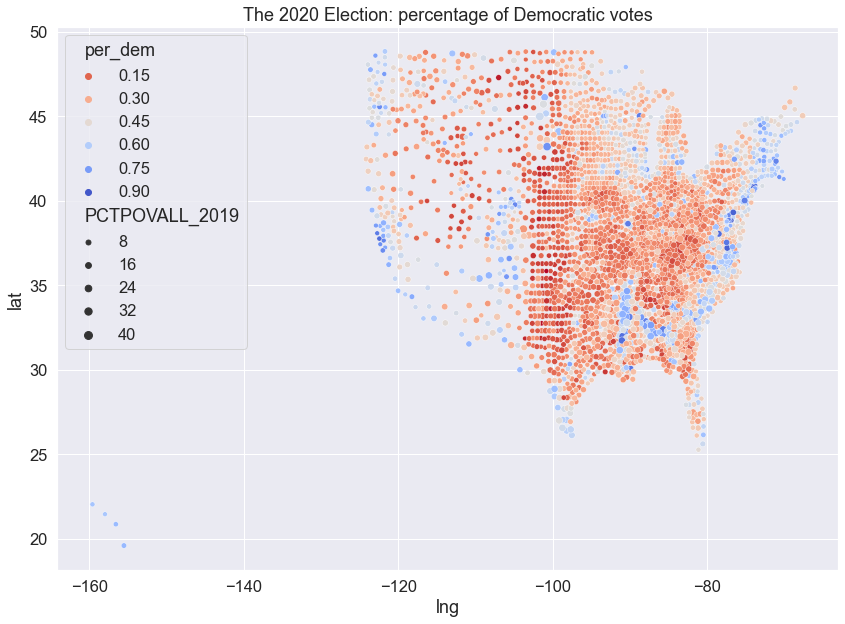

In [34]:
# Influence of the poverty on dem vote
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_educ_pov, x = "lng", y = "lat", 
                hue = "per_dem", palette = "coolwarm_r", size='PCTPOVALL_2019')
plt.title("The 2020 Election: percentage of Democratic votes")

<AxesSubplot:xlabel='target', ylabel='PCTPOV517_2019'>

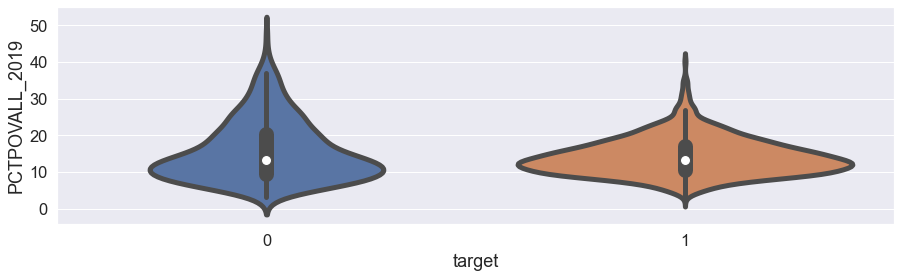

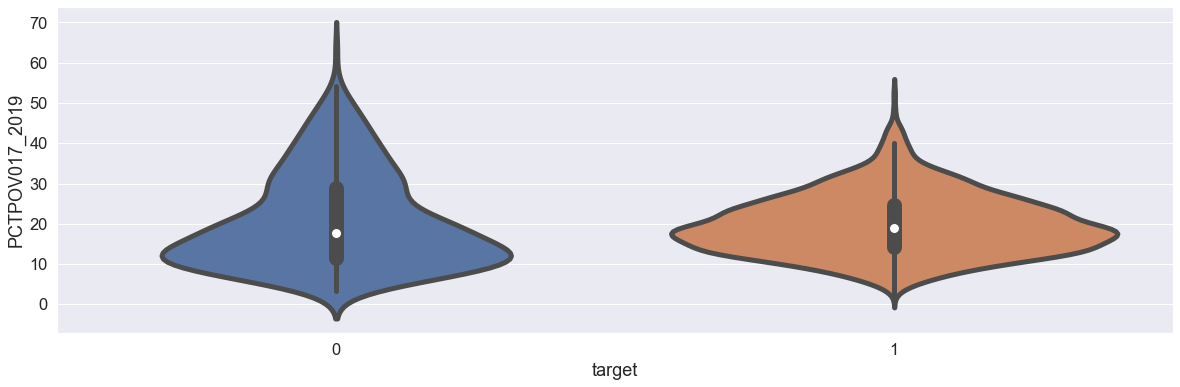

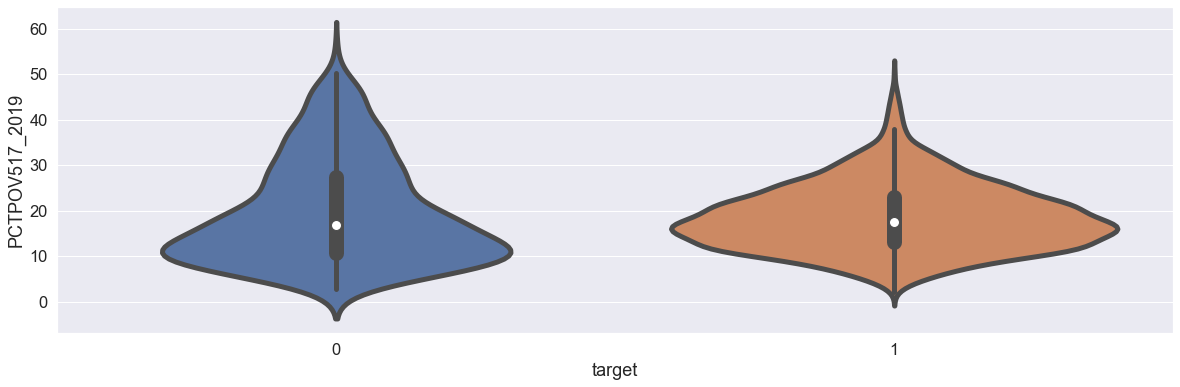

In [35]:
fig, ax = plt.subplots(figsize=(15,4))
sns.violinplot(x='target', y='PCTPOVALL_2019', inner='box', linewidth=5, data=data_educ_pov, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='PCTPOV017_2019', linewidth=5, data=data_educ_pov, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='PCTPOV517_2019', linewidth=5, data=data_educ_pov, ax=ax)


## 1.6 Import population: merge avec data_educ_pov = data_complet

In [36]:
population = pd.read_excel('PopulationEstimates.xls', skiprows = 2)
population.columns

Index(['FIPStxt', 'State', 'Area_Name', 'Rural-urban_Continuum Code_2003',
       'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2003',
       'Urban_Influence_Code_2013', 'Economic_typology_2015',
       'CENSUS_2010_POP', 'ESTIMATES_BASE_2010',
       ...
       'R_DOMESTIC_MIG_2019', 'R_NET_MIG_2011', 'R_NET_MIG_2012',
       'R_NET_MIG_2013', 'R_NET_MIG_2014', 'R_NET_MIG_2015', 'R_NET_MIG_2016',
       'R_NET_MIG_2017', 'R_NET_MIG_2018', 'R_NET_MIG_2019'],
      dtype='object', length=165)

In [37]:
population.rename(columns={'FIPStxt':'county_fips'}, inplace=True)
population.drop(columns=['Area_Name', 'Rural-urban_Continuum Code_2003',
                         'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2003',
                         'Urban_Influence_Code_2013', 'Economic_typology_2015',
                         'CENSUS_2010_POP', 'ESTIMATES_BASE_2010'], inplace=True)

In [38]:
population=population.iloc[1:]
population.columns.to_list()

['county_fips',
 'State',
 'POP_ESTIMATE_2010',
 'POP_ESTIMATE_2011',
 'POP_ESTIMATE_2012',
 'POP_ESTIMATE_2013',
 'POP_ESTIMATE_2014',
 'POP_ESTIMATE_2015',
 'POP_ESTIMATE_2016',
 'POP_ESTIMATE_2017',
 'POP_ESTIMATE_2018',
 'POP_ESTIMATE_2019',
 'N_POP_CHG_2010',
 'N_POP_CHG_2011',
 'N_POP_CHG_2012',
 'N_POP_CHG_2013',
 'N_POP_CHG_2014',
 'N_POP_CHG_2015',
 'N_POP_CHG_2016',
 'N_POP_CHG_2017',
 'N_POP_CHG_2018',
 'N_POP_CHG_2019',
 'Births_2010',
 'Births_2011',
 'Births_2012',
 'Births_2013',
 'Births_2014',
 'Births_2015',
 'Births_2016',
 'Births_2017',
 'Births_2018',
 'Births_2019',
 'Deaths_2010',
 'Deaths_2011',
 'Deaths_2012',
 'Deaths_2013',
 'Deaths_2014',
 'Deaths_2015',
 'Deaths_2016',
 'Deaths_2017',
 'Deaths_2018',
 'Deaths_2019',
 'NATURAL_INC_2010',
 'NATURAL_INC_2011',
 'NATURAL_INC_2012',
 'NATURAL_INC_2013',
 'NATURAL_INC_2014',
 'NATURAL_INC_2015',
 'NATURAL_INC_2016',
 'NATURAL_INC_2017',
 'NATURAL_INC_2018',
 'NATURAL_INC_2019',
 'INTERNATIONAL_MIG_2010',
 'INTER

In [39]:
data_complet = pd.merge(data_educ_pov, population, how="left", on=["county_fips"])

In [40]:
data_complet.describe()

county_fips     votes_gop     votes_dem   total_votes      per_gop  \
count   3152.000000  3.152000e+03  3.152000e+03  3.152000e+03  3152.000000   
mean   30299.778236  2.354321e+04  2.578204e+04  5.026445e+04     0.647805   
std    15209.461517  5.403994e+04  9.693023e+04  1.493792e+05     0.162014   
min     1001.000000  6.000000e+01  4.000000e+00  6.600000e+01     0.053973   
25%    18162.500000  3.661500e+03  1.319500e+03  5.414750e+03     0.554128   
50%    29166.000000  8.123000e+03  3.690000e+03  1.233550e+04     0.681720   
75%    45075.500000  2.050875e+04  1.194450e+04  3.330450e+04     0.773776   
max    56045.000000  1.145530e+06  3.028885e+06  4.263443e+06     0.961818   

           per_dem       target          lng          lat  pc_no_diploma_90  \
count  3152.000000  3152.000000  3111.000000  3111.000000       3111.000000   
mean      0.333851     0.823287   -91.745306    38.256516         30.443748   
std       0.159852     0.381486    11.714154     4.872711         10.340168   
min       0.030909     0.000000  -159.595750    19.601235          4.500000   
25%       0.209978     1.000000   -98.066817    34.656998         22.800000   
50%       0.300235     1.000000   -90.207494    38.324423         28.600000   
75%       0.425830     1.000000   -83.401385    41.686126         38.150000   
max       0.921497     1.000000   -67.629108    48.825953         68.400000   

       pc_high_school_90  pc_degree_90  pc_high_degree_90  pc_no_diploma_00  \
count        3111.000000   3111.000000        3111.000000       3111.000000   
mean           34.293057     21.773192          13.489489         22.653970   
std             6.147550      5.900026           6.575543          8.725873   
min            13.500000      6.800000           3.700000          3.000000   
25%            30.300000     17.300000           9.200000         16.100000   
50%            33.800000     21.700000          11.800000         20.800000   
75%            38.500000     25.900000          15.600000         28.800000   
max            52.600000     43.300000          53.400000         65.300000   

       pc_high_school_00  pc_degree_00  pc_high_degree_00  \
count        3111.000000   3111.000000        3111.000000   
mean           34.698329     26.129572          16.516651   
std             6.559755      5.633778           7.800555   
min            10.900000      9.900000           4.900000   
25%            30.700000     22.100000          11.200000   
50%            34.800000     26.200000          14.500000   
75%            38.950000     30.100000          19.300000   
max            53.200000     44.900000          63.700000   

       pc_no_diploma_15-19  pc_high_school_15-19  pc_degree_15-19  \
count          3112.000000           3112.000000      3112.000000   
mean             13.085088             34.147758        30.802965   
std               6.265950              7.226061         5.211923   
min               1.116910              7.265136         5.235602   
25%               8.479882             29.689806        27.290243   
50%              11.739182             34.538523        30.785382   
75%              16.708521             39.099957        34.214836   
max              73.560211             57.433674        60.563381   

       pc_high_degree_15-19  PCTPOVALL_2019  PCTPOV017_2019  PCTPOV517_2019  \
count           3112.000000     3112.000000     3112.000000     3112.000000   
mean              21.964189       14.470662       19.998008       18.760347   
std                9.582236        5.793896        8.493742        8.239852   
min                0.000000        2.700000        2.400000        2.200000   
25%               15.325250       10.400000       13.700000       12.600000   
50%               19.557242       13.400000       18.700000       17.500000   
75%               25.989834       17.500000       24.925000       23.500000   
max               77.557411       47.700000       63.400000       55.000000  

# 2. Premières modélisations avec 2 variables


## 2.1 Choix des variables

In [41]:
mat_cor=data_complet.corr()

In [44]:
mat_cor['per_gop'].sort_values(ascending=False)

per_gop                     1.000000
target                      0.781093
pc_high_school_00           0.497250
pc_high_school_15-19        0.488548
R_death_2012                0.394333
R_death_2013                0.384782
R_death_2014                0.383803
pc_high_school_90           0.378037
R_death_2015                0.377787
R_death_2011                0.377161
R_death_2017                0.366228
R_death_2016                0.360760
pc_no_diploma_90            0.271382
R_death_2018                0.253079
R_death_2019                0.226521
pc_no_diploma_00            0.194518
pc_degree_15-19             0.154604
DOMESTIC_MIG_2019           0.136656
DOMESTIC_MIG_2018           0.136637
pc_no_diploma_15-19         0.134040
DOMESTIC_MIG_2017           0.126101
DOMESTIC_MIG_2016           0.105696
DOMESTIC_MIG_2015           0.092276
DOMESTIC_MIG_2014           0.081729
DOMESTIC_MIG_2010           0.080507
county_fips                 0.076310
DOMESTIC_MIG_2013           0.065824
R

In [62]:
# Visualisation avec 2 variables
data_visu=data_complet[['pc_high_school_00','PCTPOV517_2019','target']]
#data_visu=data_complet[['pc_no_diploma_00','R_death_2012','target']]

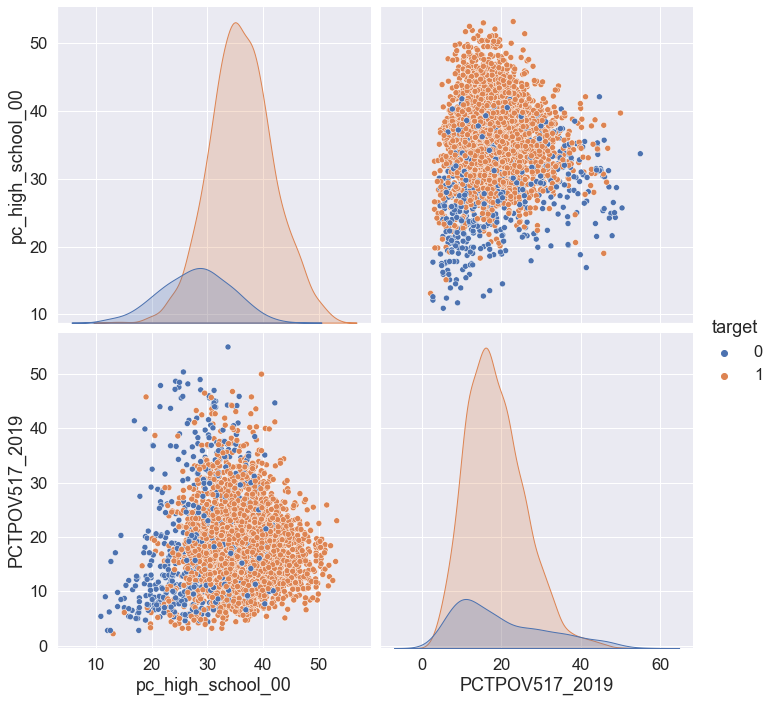

In [63]:
sns.pairplot(data_visu, hue="target", height=5)

In [54]:
fig = px.scatter_3d(data_complet, x='pc_high_school_00', y='R_death_2012', z='PCTPOV517_2019',
              color='target')
fig.show()

## 2.2 Régression logistique

https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

Text(0.5, 1.0, 'The 2020 Election: percentage of Democratic votes')

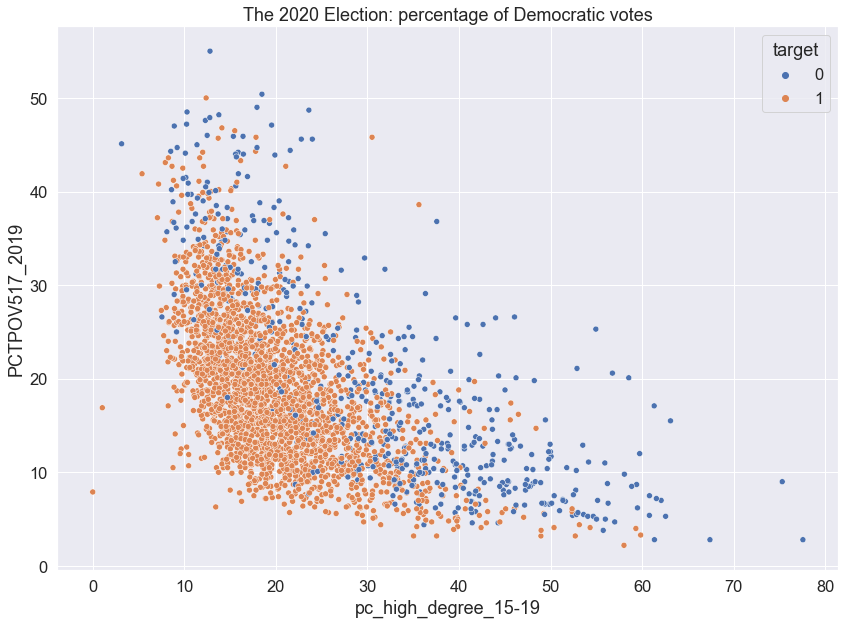

In [64]:
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_complet, x = 'pc_high_degree_15-19', y = 'PCTPOV517_2019', 
                hue = "target")
plt.title("The 2020 Election: percentage of Democratic votes")

In [161]:
#X=data_educ_pov[['pc_high_degree_15-19','PCTPOV517_2019']].values
#y=data_educ_pov[['target']].values.ravel()

In [103]:
#X=data_complet[['pc_high_degree_15-19','PCTPOV517_2019']]
X=data_complet[['pc_high_degree_15-19','PCTPOV517_2019', 'R_death_2012']]
y=data_complet[['target']]

In [60]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [104]:
# pipeline complet
#preproc = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

log_reg = LogisticRegression()

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('log_reg', log_reg)
])

pipe.fit(X_train,y_train)

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [105]:
y_pred = pipe.predict(X_valid)
print("Bilan de la régression logistique de base:")
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred)} ")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred):.2f}.")

Bilan de la régression logistique de base:
- La matrice de confusion est: 
[[ 54  65]
 [ 24 488]] 
- Le score f1 vaut: 0.92.
- Le recall vaut: 0.95.
- La précision vaut: 0.88.


In [71]:
 pipe[-1].coef_[0]

array([-1.97425668, -1.30847431])

In [48]:
#Accuracy=491/(491+66)
#print(Accuracy)

In [106]:
coefs = pipe[-1].coef_[0]  # coefficients = 2d array
weights = pd.Series(coefs, index=X.columns.to_list())

In [108]:
#weights

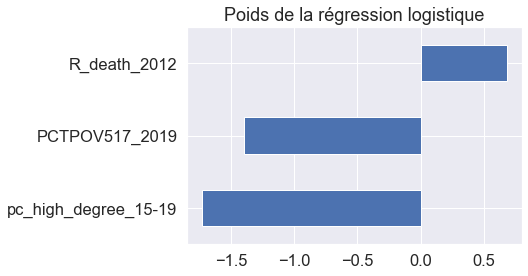

In [107]:
weights.plot.barh()
_ = plt.title("Poids de la régression logistique")

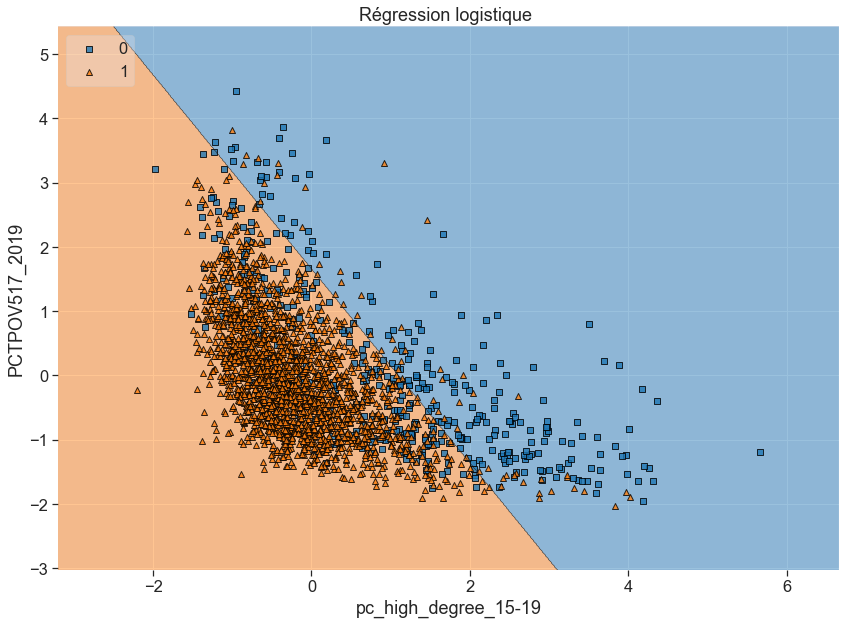

In [53]:
# pipeline sur le preprocessing pour X
# transformation y en vecteur
# pour affichage des frontières de décision


X_train_pr = preproc.fit_transform(X_train)


# Plotting decision regions
ax, fig = plt.subplots(figsize = (14,10))
plot_decision_regions(X_train_pr, y_train.values.ravel(), clf=log_reg, legend=2)

# Adding axes annotations

plt.xlabel('pc_high_degree_15-19')
plt.ylabel('PCTPOV517_2019')
plt.title('Régression logistique ')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


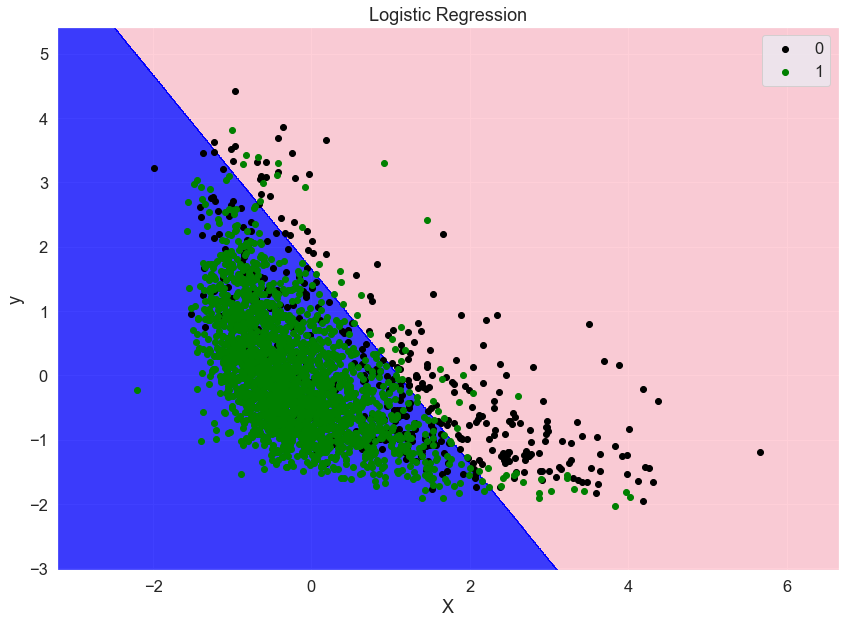

In [76]:
# La même chose avec un algo 
# https://medium.com/data-science-community-srm/mlxtend-af073ebd0c51

from matplotlib.colors import ListedColormap

ax, fig = plt.subplots(figsize = (14,10))

X_set, y_set = X_train_pr, y_train.values.ravel()
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, log_reg.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('pink', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('black', 'green'))(i), label = j)
plt.title('Logistic Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## 2.3 Régression logistique avec gridsearch

In [109]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


# Utilisation de gridsearch CV avec une régression logistique


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('logreg', log_reg)
])

# Create new parameter dictionary
grid_params = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'logreg__solver' : ('saga', 'liblinear'),
    'logreg__penalty': ('l1', 'l2'),
    'logreg__C': (0.01, 0.1, 1, 10),
    'logreg__fit_intercept': (True, False)}



# Créatio de l'objet gridsearch object 
    
gs_reg = GridSearchCV(pipe, grid_params)

gs_reg.fit(X_train,y_train.values.ravel())

GridSearchCV(estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': (0.01, 0.1, 1, 10),
                         'logreg__fit_intercept': (True, False),
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ('saga', 'liblinear')})

In [110]:
best_reg = gs_reg.best_estimator_

In [111]:
# Score the model on our testing data
y_pred_best_reg = best_reg.predict(X_valid)
print('Bilan de la régression logistique optimisée:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_reg)} ")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_reg):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_reg):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_reg):.2f}.")


Bilan de la régression logistique optimisée:
- La matrice de confusion est: 
[[ 49  70]
 [ 22 490]] 
- Le score f1 vaut: 0.91.
- Le recall vaut: 0.96.
- La précision vaut: 0.88.


In [69]:
gs_reg.best_params_


{'logreg__C': 1,
 'logreg__fit_intercept': True,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

## 2.4 SVM non linéaire avec gridsearch

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [112]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


# Utilisation de gridsearch CV avec une régression logistique


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])

In [113]:
 
# defining parameter range

grid_params_svc = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'svc__C' : (0.1, 1, 10, 100, 1000),
    'svc__gamma': (1, 0.1, 0.01, 0.001),
    'svc__kernel': ['rbf','sigmoid']}


pipe_svc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])


# Création de l'objet gridsearch object  et fit


    
gs_svc = GridSearchCV(pipe_svc, grid_params_svc, cv=5, refit=True, verbose=2)

gs_svc.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.2s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.2s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.2s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.2s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.1s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END ........svc__C=0.1, svc__gamma=0.1, sv

[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=0.01, svc__kernel=sigmoid; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=0.01, svc__kernel=sigmoid; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=0.01, svc__kernel=sigmoid; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=0.01, svc__kernel=sigmoid; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=0.01, svc__kernel=sigmoid; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=10, s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': (0.1, 1, 10, 100, 1000),
                         'svc__gamma': (1, 0.1, 0.01, 0.001),
                         'svc__kernel': ['rbf', 'sigmoid']},
             verbose=2)

In [114]:
best_svm = gs_svc.best_estimator_

In [115]:
# Score the model on our testing data
y_pred_best_svm = best_svm.predict(X_valid)
print('Bilan de la svm optimisée:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_svm)} ")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_svm):.2f}.")


Bilan de la svm optimisée:
- La matrice de confusion est: 
[[ 48  71]
 [ 18 494]] 
- Le score f1 vaut: 0.92.
- Le recall vaut: 0.96.
- La précision vaut: 0.87.


In [78]:
#scores = gs_svc.cv_results_['mean_test_score']
#scores.sort()
#scores

In [116]:
print('Voici les meilleurs paramètres pour la SVM:')
gs_svc.best_params_

Voici les meilleurs paramètres pour la SVM:


{'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'sigmoid'}

In [76]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)



pipe_svc_best = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC(C=1000, gamma=0.1, kernel='rbf'))
])


preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])

svc = SVC(C=1000, gamma=0.1, kernel='rbf')


####################### 

X_train_pr = preproc.fit_transform(X_train)

svc.fit(X_train_pr,y_train.values.ravel())


#######################


#pipe_svc_best.fit(X_train,y_train.values.ravel())



SVC(C=1000, gamma=0.1)

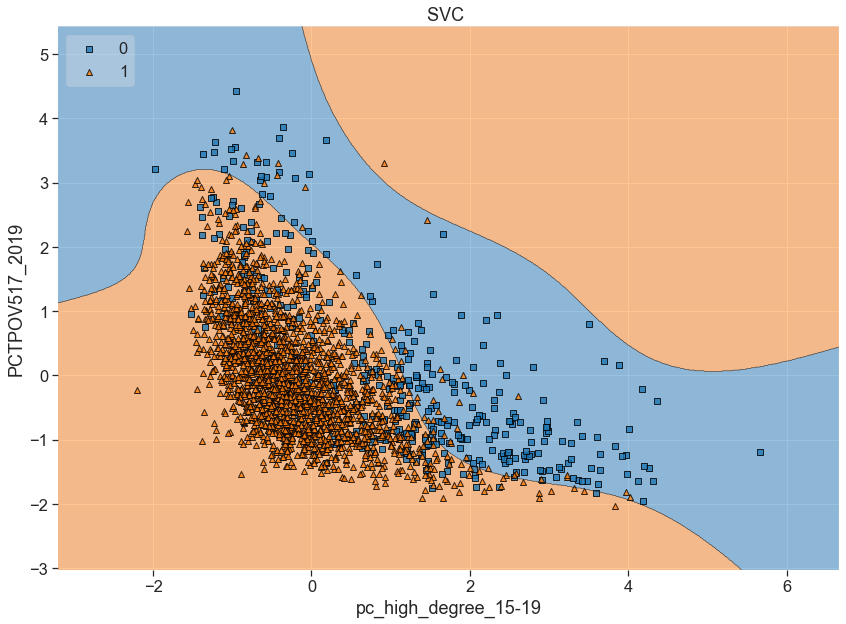

In [77]:
#######################

# Plotting decision regions
ax, fig = plt.subplots(figsize = (14,10))
plot_decision_regions(X_train_pr, y_train.values.ravel(), clf=svc, legend=2)

# Adding axes annotations

plt.xlabel('pc_high_degree_15-19')
plt.ylabel('PCTPOV517_2019')
plt.title('SVC ')
plt.show()

* https://zekehochberg.github.io/pipeline-and-gridsearch/
* https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

# 3. Random forest: choix des variables les plus influentes

-https://www.kaggle.com/code/pepacz/randomforestclassifier-with-sklearn-pipeline

## 3.1. Choix des variables: préselection initiale

In [157]:
X=data_complet.iloc[:,12:]
X.drop(columns=['State'], inplace=True)

In [158]:
list_col=X.columns.tolist()

In [159]:
list_col

['pc_no_diploma_90',
 'pc_high_school_90',
 'pc_degree_90',
 'pc_high_degree_90',
 'pc_no_diploma_00',
 'pc_high_school_00',
 'pc_degree_00',
 'pc_high_degree_00',
 'pc_no_diploma_15-19',
 'pc_high_school_15-19',
 'pc_degree_15-19',
 'pc_high_degree_15-19',
 'PCTPOVALL_2019',
 'PCTPOV017_2019',
 'PCTPOV517_2019',
 'POP_ESTIMATE_2010',
 'POP_ESTIMATE_2011',
 'POP_ESTIMATE_2012',
 'POP_ESTIMATE_2013',
 'POP_ESTIMATE_2014',
 'POP_ESTIMATE_2015',
 'POP_ESTIMATE_2016',
 'POP_ESTIMATE_2017',
 'POP_ESTIMATE_2018',
 'POP_ESTIMATE_2019',
 'N_POP_CHG_2010',
 'N_POP_CHG_2011',
 'N_POP_CHG_2012',
 'N_POP_CHG_2013',
 'N_POP_CHG_2014',
 'N_POP_CHG_2015',
 'N_POP_CHG_2016',
 'N_POP_CHG_2017',
 'N_POP_CHG_2018',
 'N_POP_CHG_2019',
 'Births_2010',
 'Births_2011',
 'Births_2012',
 'Births_2013',
 'Births_2014',
 'Births_2015',
 'Births_2016',
 'Births_2017',
 'Births_2018',
 'Births_2019',
 'Deaths_2010',
 'Deaths_2011',
 'Deaths_2012',
 'Deaths_2013',
 'Deaths_2014',
 'Deaths_2015',
 'Deaths_2016',
 'D

In [160]:
col_sel=['PCTPOVALL_2019',
 'PCTPOV017_2019',
 'PCTPOV517_2019',
'pc_no_diploma_90',
 'pc_high_school_90',
 'pc_degree_90',
 'pc_high_degree_90',
 'pc_no_diploma_00',
 'pc_high_school_00',
 'pc_degree_00',
 'pc_high_degree_00',
 'pc_no_diploma_15-19',
 'pc_high_school_15-19',
 'pc_degree_15-19',
 'pc_high_degree_15-19',
 'R_birth_2011',
 'R_birth_2012',
 'R_birth_2013',
 'R_birth_2014',
 'R_birth_2015',
 'R_birth_2016',
 'R_birth_2017',
 'R_birth_2018',
 'R_birth_2019',
 'R_death_2011',
 'R_death_2012',
 'R_death_2013',
 'R_death_2014',
 'R_death_2015',
 'R_death_2016',
 'R_death_2017',
 'R_death_2018',
 'R_death_2019',
 'R_NATURAL_INC_2011',
 'R_NATURAL_INC_2012',
 'R_NATURAL_INC_2013',
 'R_NATURAL_INC_2014',
 'R_NATURAL_INC_2015',
 'R_NATURAL_INC_2016',
 'R_NATURAL_INC_2017',
 'R_NATURAL_INC_2018',
 'R_NATURAL_INC_2019',
 'R_INTERNATIONAL_MIG_2011',
 'R_INTERNATIONAL_MIG_2012',
 'R_INTERNATIONAL_MIG_2013',
 'R_INTERNATIONAL_MIG_2014',
 'R_INTERNATIONAL_MIG_2015',
 'R_INTERNATIONAL_MIG_2016',
 'R_INTERNATIONAL_MIG_2017',
 'R_INTERNATIONAL_MIG_2018',
 'R_INTERNATIONAL_MIG_2019',
 'R_DOMESTIC_MIG_2011',
 'R_DOMESTIC_MIG_2012',
 'R_DOMESTIC_MIG_2013',
 'R_DOMESTIC_MIG_2014',
 'R_DOMESTIC_MIG_2015',
 'R_DOMESTIC_MIG_2016',
 'R_DOMESTIC_MIG_2017',
 'R_DOMESTIC_MIG_2018',
 'R_DOMESTIC_MIG_2019',
 'R_NET_MIG_2011',
 'R_NET_MIG_2012',
 'R_NET_MIG_2013',
 'R_NET_MIG_2014',
 'R_NET_MIG_2015',
 'R_NET_MIG_2016',
 'R_NET_MIG_2017',
 'R_NET_MIG_2018',
 'R_NET_MIG_2019']

       
         
         
         
         

In [161]:
X=X[col_sel]

In [162]:
X.describe()

PCTPOVALL_2019  PCTPOV017_2019  PCTPOV517_2019  pc_no_diploma_90  \
count     3112.000000     3112.000000     3112.000000       3111.000000   
mean        14.470662       19.998008       18.760347         30.443748   
std          5.793896        8.493742        8.239852         10.340168   
min          2.700000        2.400000        2.200000          4.500000   
25%         10.400000       13.700000       12.600000         22.800000   
50%         13.400000       18.700000       17.500000         28.600000   
75%         17.500000       24.925000       23.500000         38.150000   
max         47.700000       63.400000       55.000000         68.400000   

       pc_high_school_90  pc_degree_90  pc_high_degree_90  pc_no_diploma_00  \
count        3111.000000   3111.000000        3111.000000       3111.000000   
mean           34.293057     21.773192          13.489489         22.653970   
std             6.147550      5.900026           6.575543          8.725873   
min            13.500000      6.800000           3.700000          3.000000   
25%            30.300000     17.300000           9.200000         16.100000   
50%            33.800000     21.700000          11.800000         20.800000   
75%            38.500000     25.900000          15.600000         28.800000   
max            52.600000     43.300000          53.400000         65.300000   

       pc_high_school_00  pc_degree_00  pc_high_degree_00  \
count        3111.000000   3111.000000        3111.000000   
mean           34.698329     26.129572          16.516651   
std             6.559755      5.633778           7.800555   
min            10.900000      9.900000           4.900000   
25%            30.700000     22.100000          11.200000   
50%            34.800000     26.200000          14.500000   
75%            38.950000     30.100000          19.300000   
max            53.200000     44.900000          63.700000   

       pc_no_diploma_15-19  pc_high_school_15-19  pc_degree_15-19  \
count          3112.000000           3112.000000      3112.000000   
mean             13.085088             34.147758        30.802965   
std               6.265950              7.226061         5.211923   
min               1.116910              7.265136         5.235602   
25%               8.479882             29.689806        27.290243   
50%              11.739182             34.538523        30.785382   
75%              16.708521             39.099957        34.214836   
max              73.560211             57.433674        60.563381   

       pc_high_degree_15-19  R_birth_2011  R_birth_2012  R_birth_2013  \
count           3112.000000   3112.000000   3112.000000   3112.000000   
mean              21.964189     11.707480     11.612219     11.618834   
std                9.582236      2.655749      2.643972      2.630171   
min                0.000000      2.574003      2.259887      1.445087   
25%               15.325250     10.045831      9.949819      9.994716   
50%               19.557242     11.515327     11.434897     11.459053   
75%               25.989834     13.005422     12.979334     12.940443   
max               77.557411     29.658194     30.045068     29.339398   

       R_birth_2014  R_birth_2015  R_birth_2016  R_birth_2017  R_birth_2018  \
count   3112.000000   3112.000000   3112.000000   3112.000000   3112.000000   
mean      11.680572     11.729868     11.645475     11.437929     11.133515   
std        2.625713      2.604639      2.464632      2.505717      2.444717   
min        3.590664      3.646308      2.072539      0.000000      0.000000   
25%       10.085164     10.157151     10.118679      9.916906      9.690347   
50%       11.513618     11.522429     11.478833     11.300128     11.043734   
75%       13.052812     13.049309     12.858924     12.733382     12.358365   
max       29.114243     30.412840     29.038718     28.490465     28.538363   

       R_birth_2019  R_death_2011  R_death_2012  R_death_2013  R_death_2014  

## 3.2. Modèle de base

In [163]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


# Utilisation de gridsearch CV avec une random forest


rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=10, 
                                random_state=42)

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])

pipe_rf = Pipeline([
    ('preprocessor', preproc), 
    ('classifier', rf_clf)
])

pipe_rf.fit(X_train, y_train)

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=10,
                                        random_state=42))])

In [166]:
# Score the model on our testing data
y_pred_rnd_for = pipe_rf.predict(X_valid)
print("Bilan d'une forêt aléatoire simple:")
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_rnd_for)} ")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_rnd_for):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_rnd_for):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_rnd_for):.2f}.")


Bilan d'une forêt aléatoire simple:
- La matrice de confusion est: 
[[ 67  52]
 [ 23 489]] 
- Le score f1 vaut: 0.93.
- Le recall vaut: 0.96.
- La précision vaut: 0.90.


## 3.3. Optimisation: degré de randomization

In [121]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
thresholds = np.linspace(0.01, 1, num=10)
scores = []

for t in thresholds:
    rf_clf = RandomForestClassifier(n_estimators=200, 
                                    max_features=t,
                                    n_jobs=10, 
                                    random_state=42)

    pipe_rf = Pipeline([
        ('preprocessor', preproc), 
        ('classifier', rf_clf)
    ])

    y_train_pred = cross_val_predict(pipe_rf, X_train, y_train, 
                                     cv=5, n_jobs=5)

    scores.append(f1_score(y_train, y_train_pred))

Valeur optimale de max_features : 0.45
Score F1 : 0.9384507371869881


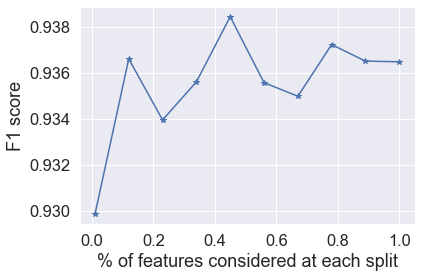

In [170]:
plt.plot(thresholds, scores, marker='*')
_=plt.xlabel("% of features considered at each split")
_=plt.ylabel("F1 score")

print(f"Valeur optimale de max_features : {thresholds[np.argmax(scores)]}")
print(f"Score F1 : {np.max(scores)}")

## 3.4. Importance des variables

In [171]:
_ = pipe_rf.fit(X_train, y_train)

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [173]:
col_names = X_train.columns
features_importances = pipe_rf.named_steps["classifier"].feature_importances_
forest_importances = pd.Series(features_importances, index=col_names)

In [183]:
forest_importances.sort_values(ascending=False, inplace=True)

In [193]:
# Choix des 10 premières variables
forest_importances=forest_importances.iloc[:10]

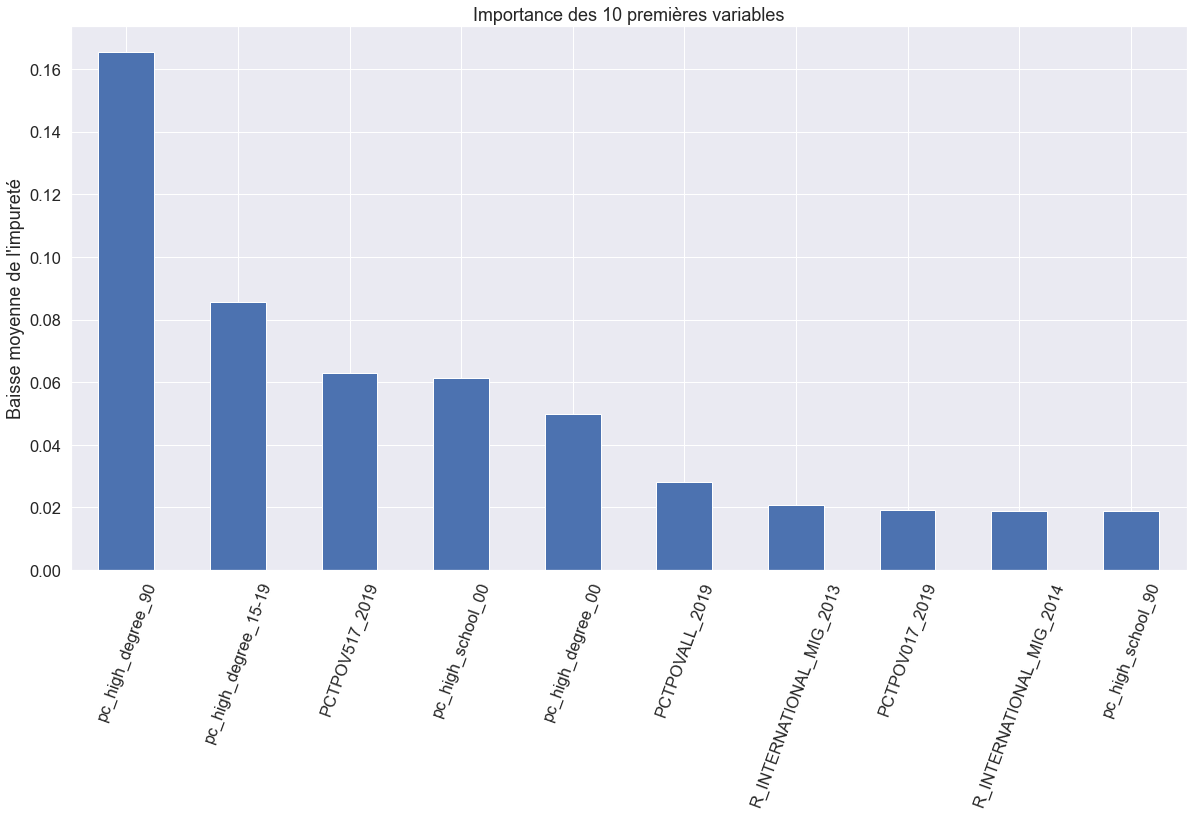

In [194]:
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(ax=ax)
ax.set_title("Importance des 10 premières variables")
ax.set_ylabel("Baisse moyenne de l'impureté")
_=plt.xticks(rotation = 70)
#fig.tight_layout()

In [267]:
# Sélection fine des variables
fine_selection = forest_importances.index[0:20]

In [200]:
# Mise à jour de X à partir des résultats de random forest
X=X[fine_selection]

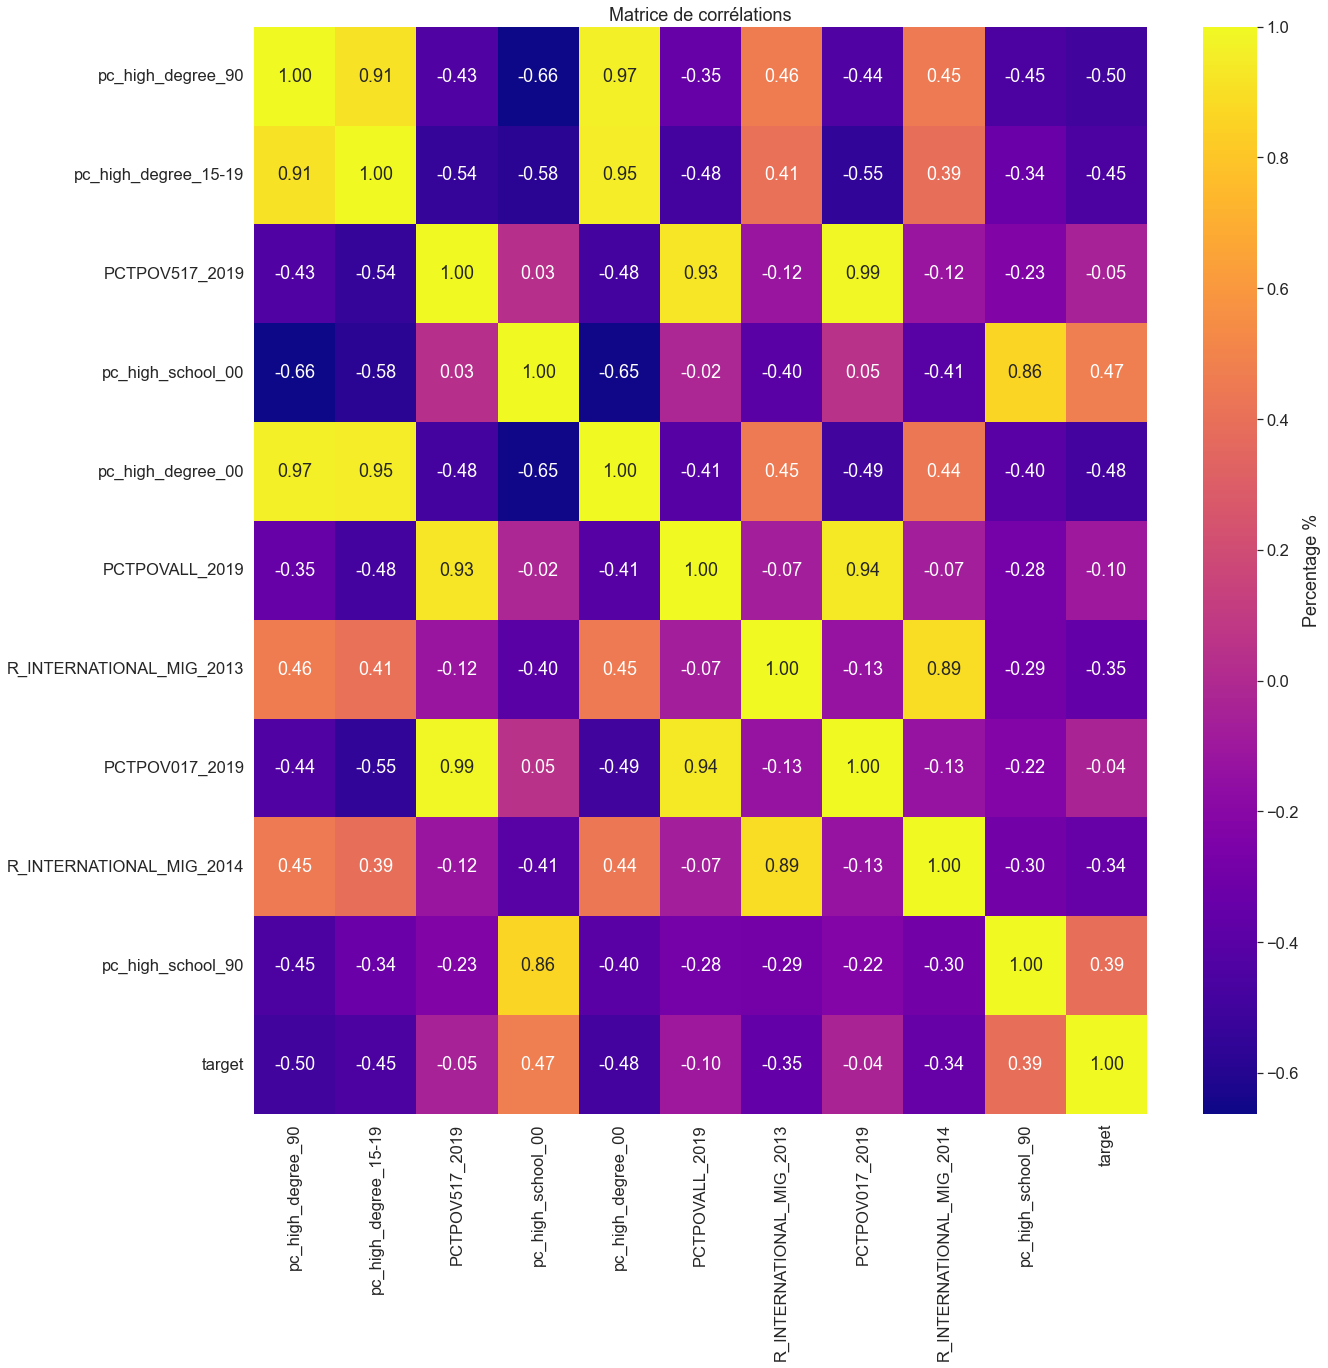

In [231]:
# Visualisation des corrélations
f, ax = plt.subplots(figsize=[20,20])
sns.heatmap(pd.concat([X, y], axis=1).corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
ax.set_title("Matrice de corrélations")
plt.show()

# 4.0 XGBoost

In [274]:
X=data_complet.iloc[:,12:]
X.drop(columns=['State'], inplace=True)
fine_selection = forest_importances.index[0:30]
X=X[fine_selection]

In [275]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [281]:
# Création d'une pipeline

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])

model=xgb.XGBClassifier()

pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('model', model )])

# Définition de la grille de parametres

param_list = {"model__max_depth": (3,5,8,10),
              "model__min_child_weight" : (1,2,3,4,5),
              "model__n_estimators": (3,5,10),
               "model__learning_rate": [0.0001,0.001,0.005,0.01],}
# grid search

gs_xgb = GridSearchCV(pipe_xgb, param_list, cv=5, refit=True, verbose=2, scoring=f1_score)


gs_xgb.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__ma

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimator

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimator

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimato

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.0001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total ti

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total ti

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total tim

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total tim

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total tim

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total tim

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; to

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.001, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total tim

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total 

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total ti

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total tim

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; t

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; tot

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.005, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=3; total time=   0

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__n_estimators=10; total time=   0

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=3; total time=   0

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=4, model__n_estimators=10; total time=   0

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=3; total time=   0

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=3; total time=   0.

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=3; total time=   0.

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=1, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=2, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=3, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=4, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=3; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time

C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\

[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=5; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.01, model__max_depth=10, model__min_child_weight=5, model__n_estimators=10; total time=   0.0s


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given


C:\Users\jarjayes\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan na

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'model__learning_rate': [0.0001, 0.001, 0.005, 0.01],
                         'model__max_depth': (3, 5, 8, 10),
                         'model__min_child_weight': (1, 2, 3, 4, 5),
                         'model__n_estimators': (3, 5, 10)},
             scoring=<function f1_score at 0x000002A151598700>, verbose=2)

In [271]:
#sk.metrics.get_scorer_names()

In [282]:
gs_xgb.best_params_

{'model__learning_rate': 0.0001,
 'model__max_depth': 3,
 'model__min_child_weight': 1,
 'model__n_estimators': 3}

In [283]:
best_xgb=gs_xgb.best_estimator_

# Score the model on our testing data
y_pred_best_svm = best_xgb.predict(X_valid)
print('Bilan avec XGBOOST:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_svm)} ")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_svm):.2f}.")


Bilan avec XGBOOST:
- La matrice de confusion est: 
[[ 50  69]
 [ 25 487]] 
- Le score f1 vaut: 0.91.
- Le recall vaut: 0.95.
- La précision vaut: 0.88.
